# Imports & Constants

In [4]:
import numpy as np
import pandas as pd
import sys

import pickle as pkl
import re

import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor

from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error as mae, mean_absolute_percentage_error as mape, r2_score

In [5]:
sys.path.append('../data')

CSV_POSTFIX = 'csv'
PATH_TO_DATASET = '../data/'

PATH_TO_TRAIN = f'{PATH_TO_DATASET}/train.{CSV_POSTFIX}'
PATH_TO_TEST = f'{PATH_TO_DATASET}/test.{CSV_POSTFIX}'

In [6]:
train_data = pd.read_csv(PATH_TO_TRAIN)
for col in train_data:
    train_data = train_data.rename(columns={col: col.lower().replace(' ', '_')})
    col = col.lower().replace(' ', '_')
    if train_data[col].dtype == 'object':
        train_data[col] = train_data[col].apply(lambda x: x.lower())


test_data = pd.read_csv(PATH_TO_TEST)
for col in test_data:
    test_data = test_data.rename(columns={col: col.lower().replace(' ', '_')})
    col = col.lower().replace(' ', '_')
    if test_data[col].dtype == 'object':
        test_data[col] = test_data[col].apply(lambda x: x.lower())

train_data.head()

,id,price,levy,manufacturer,model,prod._year,category,leather_interior,fuel_type,engine_volume,mileage,cylinders,gear_box_type,drive_wheels,doors,wheel,color,airbags
0,45654403,13328,1399,lexus,rx 450,2010,jeep,yes,hybrid,3.5,186005 km,6.0,automatic,4x4,04-may,left wheel,silver,12
1,44731507,16621,1018,chevrolet,equinox,2011,jeep,no,petrol,3,192000 km,6.0,tiptronic,4x4,04-may,left wheel,black,8
2,45774419,8467,-,honda,fit,2006,hatchback,no,petrol,1.3,200000 km,4.0,variator,front,04-may,right-hand drive,black,2
3,45769185,3607,862,ford,escape,2011,jeep,yes,hybrid,2.5,168966 km,4.0,automatic,4x4,04-may,left wheel,white,0
4,45809263,11726,446,honda,fit,2014,hatchback,yes,petrol,1.3,91901 km,4.0,automatic,front,04-may,left wheel,silver,4


In [7]:
train_data.columns

Index(['id', 'price', 'levy', 'manufacturer', 'model', 'prod._year',
       'category', 'leather_interior', 'fuel_type', 'engine_volume', 'mileage',
       'cylinders', 'gear_box_type', 'drive_wheels', 'doors', 'wheel', 'color',
       'airbags'],
      dtype='object')

In [8]:
test_data.head()

,id,levy,manufacturer,model,prod._year,category,leather_interior,fuel_type,engine_volume,mileage,cylinders,gear_box_type,drive_wheels,doors,wheel,color,airbags,price
0,44020629,-,volkswagen,golf,2012,hatchback,no,diesel,2.0 turbo,0 km,4,manual,front,02-mar,left wheel,grey,10,NaN
1,45784798,-,hyundai,sonata,2012,sedan,yes,petrol,2.4,26000 km,4,tiptronic,front,04-may,left wheel,grey,10,NaN
2,45800257,-,nissan,tiida,2005,sedan,no,petrol,1.5,168000 km,4,automatic,front,04-may,right-hand drive,sky blue,8,NaN
3,45797981,975,volvo,xc90,2012,jeep,yes,petrol,3.2,143000 km,6,automatic,4x4,04-may,left wheel,blue,12,NaN
4,45814303,-,opel,astra,1993,hatchback,no,petrol,1.6,200000 km,4,manual,front,04-may,left wheel,black,0,NaN


# EDA

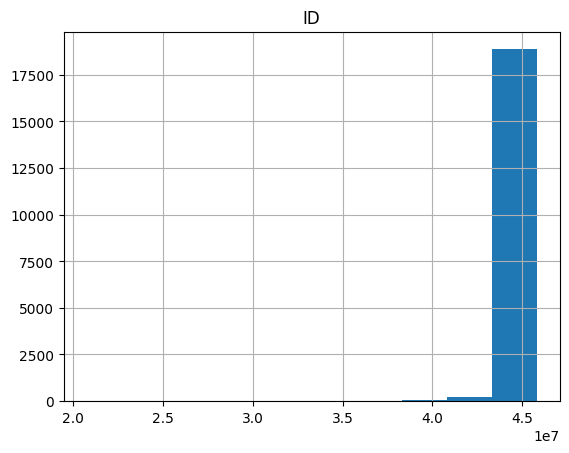

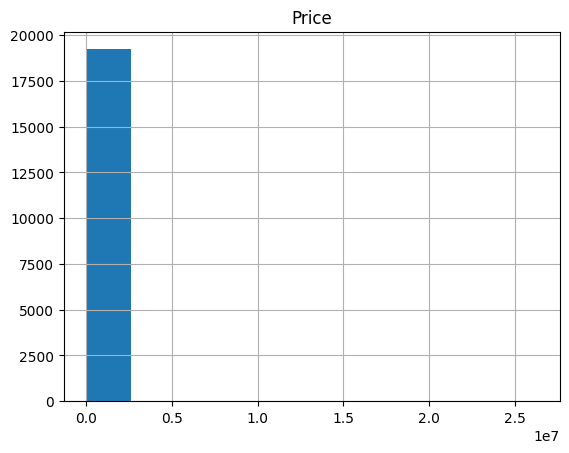

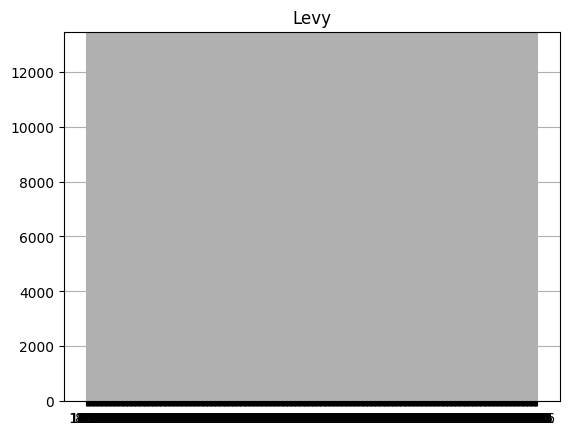

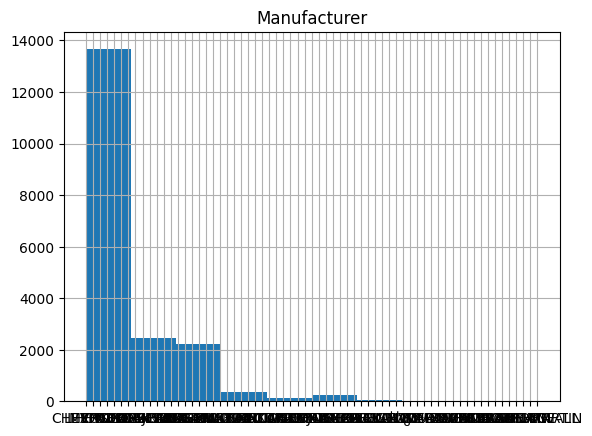

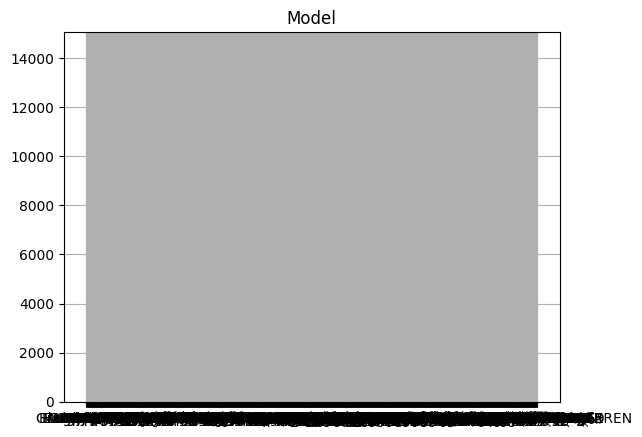

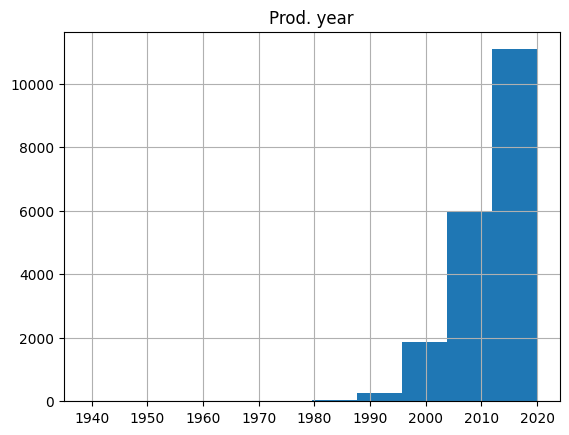

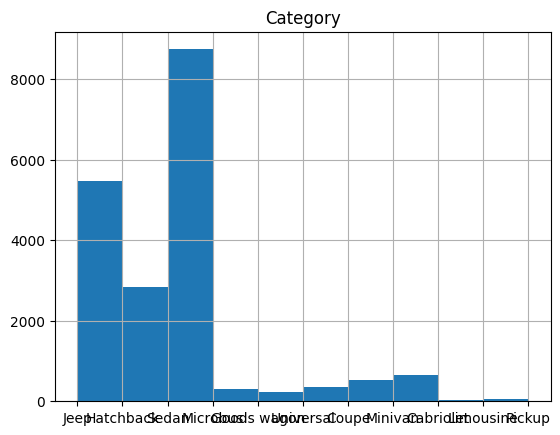

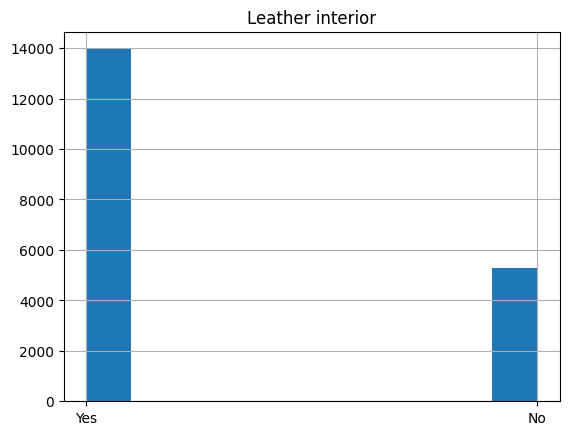

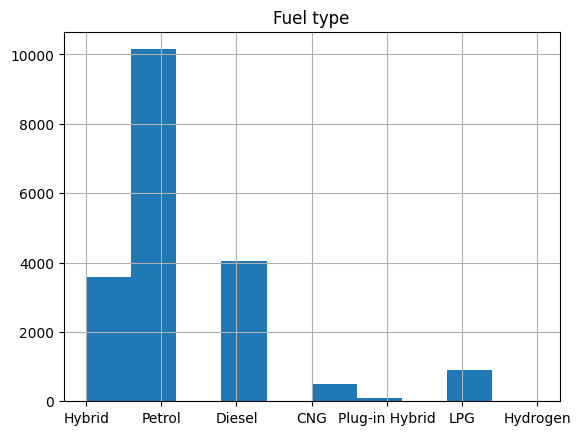

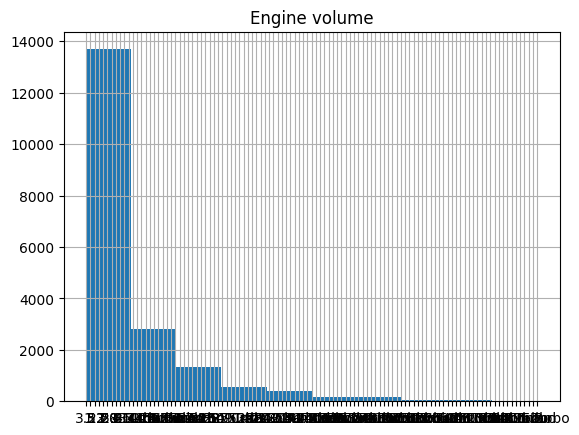

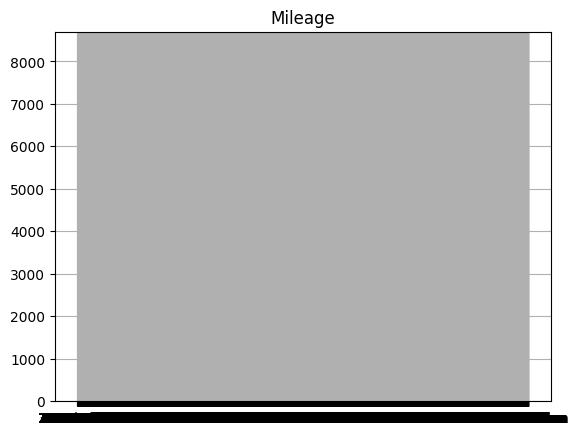

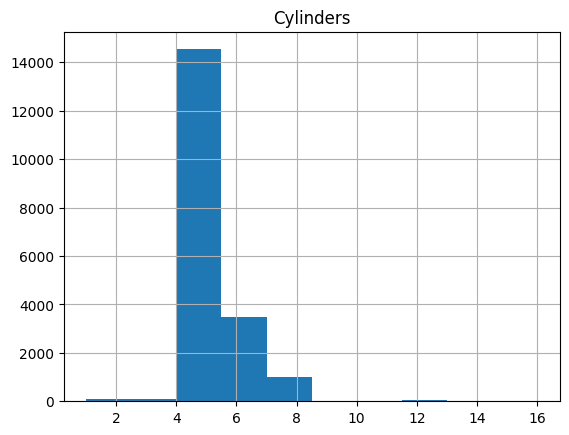

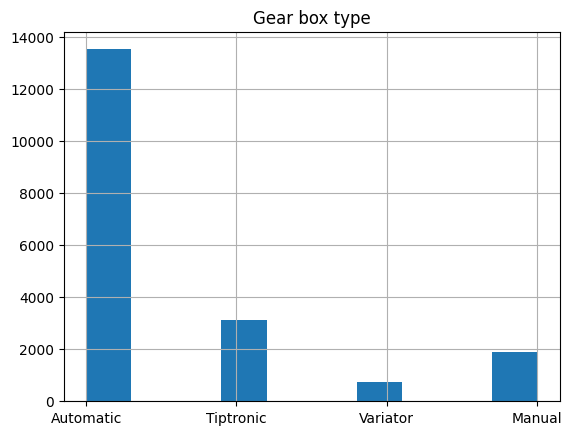

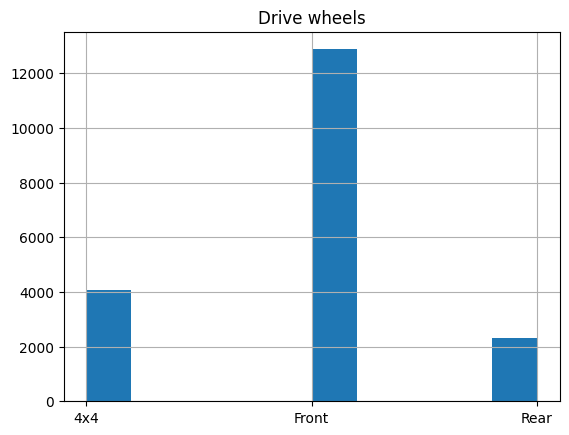

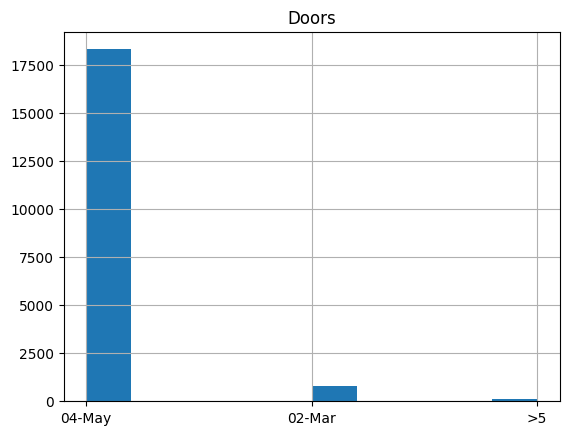

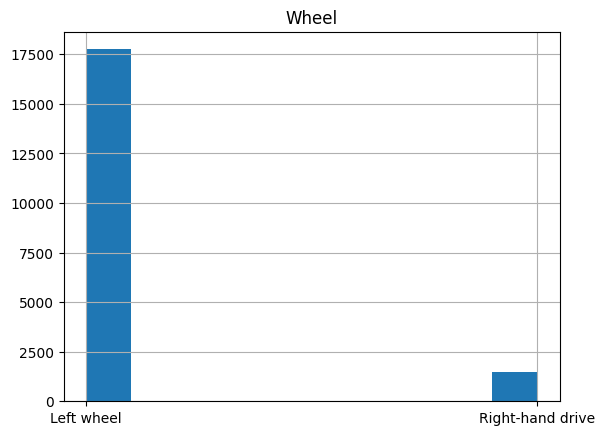

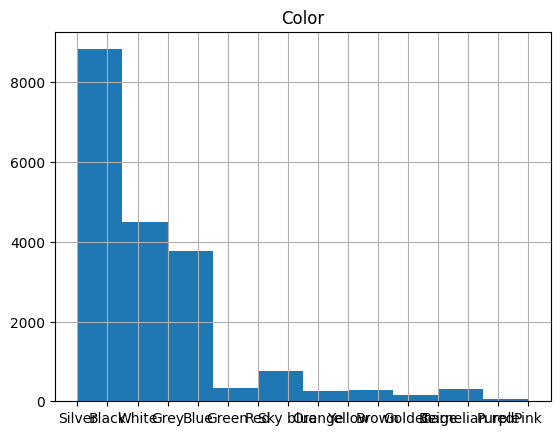

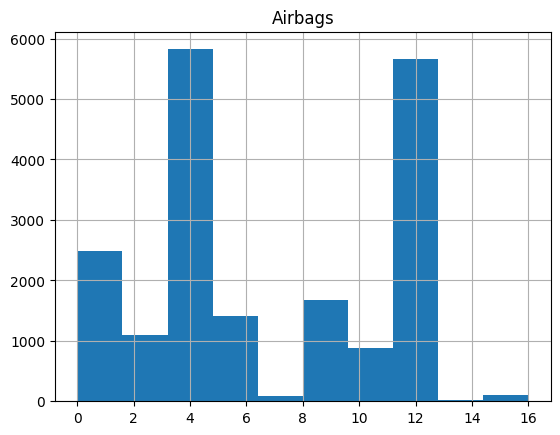

In [6]:
for column in train_data.columns:
    fig = plt.figure()
    train_data[column].hist()
    plt.title(column)
    plt.show()

# Preprocessing

## Preprocessing Categorical

In [9]:
cat_columns = [col for col in train_data.columns if train_data[col].dtype == 'object']
cat_columns

['levy',
 'manufacturer',
 'model',
 'category',
 'leather_interior',
 'fuel_type',
 'engine_volume',
 'mileage',
 'gear_box_type',
 'drive_wheels',
 'doors',
 'wheel',
 'color']

In [10]:
encoders = []
for _ in range(len(cat_columns)):
    encoders.append(LabelEncoder())

encoders = {col: encoder for col, encoder in zip(cat_columns, encoders)}

In [11]:
train_data_cp = train_data.copy()

### Doors

In [12]:
train_data['doors'] = train_data['doors'].apply(lambda x: x.replace("-mar", "").replace("-may", ""))

### Mileage

In [13]:
train_data.head()

,id,price,levy,manufacturer,model,prod._year,category,leather_interior,fuel_type,engine_volume,mileage,cylinders,gear_box_type,drive_wheels,doors,wheel,color,airbags
0,45654403,13328,1399,lexus,rx 450,2010,jeep,yes,hybrid,3.5,186005 km,6.0,automatic,4x4,04,left wheel,silver,12
1,44731507,16621,1018,chevrolet,equinox,2011,jeep,no,petrol,3,192000 km,6.0,tiptronic,4x4,04,left wheel,black,8
2,45774419,8467,-,honda,fit,2006,hatchback,no,petrol,1.3,200000 km,4.0,variator,front,04,right-hand drive,black,2
3,45769185,3607,862,ford,escape,2011,jeep,yes,hybrid,2.5,168966 km,4.0,automatic,4x4,04,left wheel,white,0
4,45809263,11726,446,honda,fit,2014,hatchback,yes,petrol,1.3,91901 km,4.0,automatic,front,04,left wheel,silver,4


In [14]:
import re

for i in range(train_data.shape[0]):
    mileage = re.search("\d+", train_data.loc[i, 'mileage']).group(0)
    train_data.loc[i, 'mileage(km)'] = int(mileage)
train_data.drop('mileage', axis=1, inplace=True)

for i in range(test_data.shape[0]):
    mileage = re.search("\d+", test_data.loc[i, 'mileage']).group(0)
    test_data.loc[i, 'mileage'] = int(mileage)
test_data.drop('mileage', axis=1, inplace=True)

cat_columns.remove('mileage')
encoders.pop('mileage')

LabelEncoder()

In [15]:
train_data.head()

,id,price,levy,manufacturer,model,prod._year,category,leather_interior,fuel_type,engine_volume,cylinders,gear_box_type,drive_wheels,doors,wheel,color,airbags,mileage(km)
0,45654403,13328,1399,lexus,rx 450,2010,jeep,yes,hybrid,3.5,6.0,automatic,4x4,04,left wheel,silver,12,186005.0
1,44731507,16621,1018,chevrolet,equinox,2011,jeep,no,petrol,3,6.0,tiptronic,4x4,04,left wheel,black,8,192000.0
2,45774419,8467,-,honda,fit,2006,hatchback,no,petrol,1.3,4.0,variator,front,04,right-hand drive,black,2,200000.0
3,45769185,3607,862,ford,escape,2011,jeep,yes,hybrid,2.5,4.0,automatic,4x4,04,left wheel,white,0,168966.0
4,45809263,11726,446,honda,fit,2014,hatchback,yes,petrol,1.3,4.0,automatic,front,04,left wheel,silver,4,91901.0


### Manucfacturer & Model & Engine volume

`I found  alot of samples from test which have values which are not in train.In the first stage i will remove them from test. But for future decisions it will be better to add similar samples in train
`

In [12]:
# union = set({})

# for col in train_data.columns:
#     if col in ['ID', 'Levy']:
#         continue
#     if col in cat_columns:
#         diff = set(test_data[col].apply(str.lower).unique().tolist()).difference(set(train_data[col].apply(str.lower).unique().tolist()))
#         if len(diff):
#             for diff_ in diff:
#                 idx = test_data[test_data[col].apply(str.lower).isin(diff)].index
#                 union = union.union(set(idx.tolist()))
#                 print(f"{col}: ({diff_}, {idx.values})")
#             print('='*30)
#         if col == 'Model':
#             diff_model = diff.copy()

### Encode cat from train

In [ ]:
train_data['levy'] = train_data['levy'].replace({'-': '0'}).astype(np.uint16)
cat_columns.remove('levy')
encoders.pop('levy')

for col in cat_columns:
    if train_data[col].isna().sum() > 0:
        print(col)
    train_data[col] = encoders[col].fit_transform(train_data[col])
    print(f'fit encoder for: {col}')

### Encode cat from test

In [16]:
# test_data['Levy'] = test_data['Levy'].replace({'-': '0'}).astype(np.uint16)

# for col in cat_columns:
#     if test_data[col].isna().sum() > 0:
#         print(col)
#     print(col)
#     test_data[col] = encoders[col].transform(test_data[col])

## Preprocess numerical

In [21]:
train_data.pop('id')
test_data.pop('id')

0       44020629
1       45784798
2       45800257
3       45797981
4       45814303
          ...   
8240    44824410
8241    45682346
8242    45649860
8243    45809706
8244    45813163
Name: id, Length: 8245, dtype: int64

In [22]:
train_y = train_data.pop('price')

In [23]:
pca = PCA()
train_data_pca = pca.fit_transform(train_data)

In [24]:
train_data_pca = train_data_pca[:, :3]

In [25]:
train_data_pca.shape

(19237, 3)

## Train test split

In [26]:
encoders

{'manufacturer': LabelEncoder(),
 'model': LabelEncoder(),
 'category': LabelEncoder(),
 'leather_interior': LabelEncoder(),
 'fuel_type': LabelEncoder(),
 'engine_volume': LabelEncoder(),
 'gear_box_type': LabelEncoder(),
 'drive_wheels': LabelEncoder(),
 'doors': LabelEncoder(),
 'wheel': LabelEncoder(),
 'color': LabelEncoder()}

In [27]:
train_y_log = np.log1p(train_y).values

def denorm_predict(model, x):
    return np.expm1(model.predict(x))

In [38]:
X_train, X_val, y_train, y_val = train_test_split(train_data_pca, train_y_log, test_size=0.2)
y_val_denorm = np.expm1(y_val)

In [39]:
pf = PolynomialFeatures(degree=3)
X_train_degreed = pf.fit_transform(X_train)
X_val_degreed = pf.transform(X_val)

X_train_degreed.shape, X_val_degreed.shape

((15389, 20), (3848, 20))

In [40]:
def compute_metrics(targets, preds):
    metrics = {}

    metrics['r2_score'] = r2_score(targets, preds)
    metrics['mean_absolute_error'] = mae(targets, preds)
    metrics['mean_absolute_percentage_error'] = mape(targets, preds)

    return metrics

# Fit & Predict

## Lin reg

In [ ]:
lin_reg = LinearRegression()

In [ ]:
lin_reg.fit(X_train_degreed, y_train)

LinearRegression()

In [ ]:
predictions_denorm = complete_predict(lin_reg, X_val_degreed)
compute_metrics(y_val_denorm, predictions_denorm)

{'r2_score': -166947.64765197888,
 'mean_absolute_error': 2926219.254635946,
 'mean_absolute_percentage_error': 150.9420336302451}

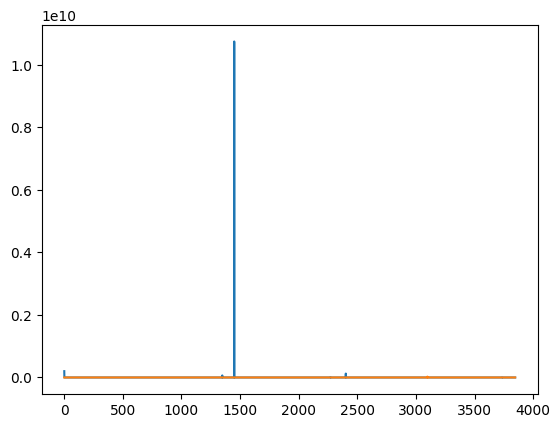

In [ ]:
plt.plot(predictions_denorm)
plt.plot(y_val_denorm)
plt.show()

## Ensembles

### XGBRegressor

In [41]:
encoders

{'manufacturer': LabelEncoder(),
 'model': LabelEncoder(),
 'category': LabelEncoder(),
 'leather_interior': LabelEncoder(),
 'fuel_type': LabelEncoder(),
 'engine_volume': LabelEncoder(),
 'gear_box_type': LabelEncoder(),
 'drive_wheels': LabelEncoder(),
 'doors': LabelEncoder(),
 'wheel': LabelEncoder(),
 'color': LabelEncoder()}

In [42]:
with open('/home/ares/work/car-price/data/predict/string_encoders.pkl', 'wb')as f:
    pkl.dump(encoders, f)

In [43]:
xgb = XGBRegressor()

xgb.fit(X_train_degreed, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [44]:
predictions_denorm = denorm_predict(xgb, X_val_degreed)
predictions_denorm

array([ 4283.3955, 25018.502 , 32694.035 , ...,  2684.454 , 35939.918 ,
        9011.133 ], dtype=float32)

In [45]:
compute_metrics(y_val_denorm, predictions_denorm)

{'r2_score': -0.0001833397924579927,
 'mean_absolute_error': 15392.772774027688,
 'mean_absolute_percentage_error': 10.962265646841608}

### Random Forest

In [34]:
rf = RandomForestRegressor()

rf.fit(X_train_degreed, y_train)

RandomForestRegressor()

In [35]:
predictions_denorm = denorm_predict(rf, X_val_degreed)

In [36]:
compute_metrics(y_val_denorm, predictions_denorm)

{'r2_score': 0.22005323998338855,
 'mean_absolute_error': 7547.019995800408,
 'mean_absolute_percentage_error': 7.865935594451397}

### Voting regressor

In [46]:
from itertools import combinations

In [47]:
combinations = [(x,y) for x,y in combinations(np.linspace(start=0.05, stop=1, num=20), r=2) if abs(x+y - 1) < 0.05]

In [ ]:
metrics = {}
import json

for estimator_weights_couple in combinations:
    w_xgb, w_rf = estimator_weights_couple

    regr = VotingRegressor(estimators=[('xgb', xgb), ('rf', rf)], weights=estimator_weights_couple)
    regr.fit(X=X_train_degreed, y=y_train)

    predictions_denorm = denorm_predict(regr, X_val_degreed)
    metrics_temp = compute_metrics(y_val_denorm, predictions_denorm)
    metrics[estimator_weights_couple] = {}
    metrics[estimator_weights_couple] = metrics_temp
    print(
        json.dumps(f'weights: {(w_xgb, w_rf)}: {metrics_temp}', indent=4)
    )

"weights: (0.05, 0.9): {'r2_score': 0.16297048260942804, 'mean_absolute_error': 8690.059813921509, 'mean_absolute_percentage_error': 7.329622666673997}"
"weights: (0.05, 0.95): {'r2_score': 0.1642630542628889, 'mean_absolute_error': 8687.833617622517, 'mean_absolute_percentage_error': 7.296794101412574}"
"weights: (0.1, 0.9): {'r2_score': 0.16894305188151082, 'mean_absolute_error': 8671.873585355588, 'mean_absolute_percentage_error': 7.772174048991982}"
"weights: (0.15, 0.85): {'r2_score': 0.1649805573691575, 'mean_absolute_error': 8694.092764507464, 'mean_absolute_percentage_error': 7.276474589024258}"
"weights: (0.2, 0.7999999999999999): {'r2_score': 0.16363563391647196, 'mean_absolute_error': 8728.510016170641, 'mean_absolute_percentage_error': 6.783470980027397}"
"weights: (0.25, 0.75): {'r2_score': 0.16520600800312013, 'mean_absolute_error': 8763.961512765838, 'mean_absolute_percentage_error': 7.308155122940018}"
"weights: (0.25, 0.7999999999999999): {'r2_score': 0.164226254403754

In [50]:
xgb = XGBRegressor()
rf = RandomForestRegressor()

regr = VotingRegressor(estimators=[("xgb", xgb), ("rf", rf)], weights=[0.4, 0.6])
regr.fit(X=X_train_degreed, y=y_train)

VotingRegressor(estimators=[('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          predictor=None, random_state=None, ...)),
                            ('rf', RandomForestRegressor())],
                weights=[0.4, 0.6])

In [51]:
compute_metrics(y_val_denorm, denorm_predict(regr, X_val_degreed))

{'r2_score': 0.00016570293935969094,
 'mean_absolute_error': 14582.981147928951,
 'mean_absolute_percentage_error': 10.930201190005073}

In [52]:
with open("/home/ares/work/car-price/data/predict/model.pkl", "wb") as f:
    pkl.dump(regr, f)

# Complete predictor

In [33]:
import numpy as np
import pandas as pd
import re
from typing import Dict, List
from sklearn.ensemble import VotingRegressor
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures
from sklearn.decomposition import PCA


class ColumnNames:
    LEVY = "levy"
    PROD_YEAR = "prod_year"
    LEATHER_INTERIOR = "leather_interior"
    MILEAGE = "mileage"
    CYLINDERS = "cylinders"
    AIRBUGS = "airbugs"
    ID = "id"
    USER_ID = "user_id"
    LEVY = "levy"
    MANUFACTURER = "manufacturer"
    MODEL = "model"
    PROD_YEAR = "prod_year"
    CATEGORY = "category"
    LEATHER_INTERIOR = "leather_interior"
    FUEL_TYPE = "fuel_type"
    ENGINE_VOLUME = "engine_volume"
    MILEAGE = "mileage"
    CYLINDERS = "cylinders"
    GEAR_BOX_TYPE = "gear_box_type"
    DRIVE_WHEELS = "drive_wheels"
    DOORS = "doors"
    WHEEL = "wheel"
    COLOR = "color"
    AIRBUGS = "airbugs"
    PRICE = "price"

    @classmethod
    def numeric_column_names(cls):
        return [
            cls.LEVY,
            cls.PROD_YEAR,
            cls.LEATHER_INTERIOR,
            cls.MILEAGE,
            cls.CYLINDERS,
            cls.AIRBUGS
        ]

    @classmethod
    def string_column_names(cls):
        return [
            cls.MANUFACTURER,
            cls.MODEL,
            cls.CATEGORY,
            cls.FUEL_TYPE,
            cls.ENGINE_VOLUME,
            cls.GEAR_BOX_TYPE,
            cls.DRIVE_WHEELS,
            cls.DOORS,
            cls.WHEEL,
            cls.COLOR
        ]


from typing import Dict, List

class StringsPreprocessor():
    def __init__(self, string_encoders: Dict[str, LabelEncoder]):
        self._string_encoders = string_encoders

    def __preprocess_mileage(self, mileage_string):
        return int(re.search("\d+", mileage_string).group(0))

    def preprocess_strings(self, x: pd.DataFrame):
        encoded_df = x.copy()
        for col in encoded_df.columns:
            encoded_df.rename(columns={col: col.lower().replace(' ', '_')}, inplace=True)

        print(encoded_df)
        col_name = 'levy'
        encoded_df[col_name] = encoded_df[col_name].replace({'-': '0'}).astype(np.uint16)

        col_name = 'mileage'
        encoded_df[col_name] = encoded_df[col_name].apply(self.__preprocess_mileage)

        for col_name, encoder in self._string_encoders.items():
            encoded_df[col_name.lower()] = encoder.transform(encoded_df[col_name].apply(str.lower))

        return encoded_df


class FullPipelineRegressor:
    def __init__(self,
                 model: VotingRegressor,
                 pca_converter: PCA,
                 feature_extender: PolynomialFeatures
                ):

        self._model = model
        self._pca_converter = pca_converter
        self._feature_extender = feature_extender

    def __denorm_predict(self, x_preprocessed):
        return np.expm1(self._model.predict(x_preprocessed))

    def __pca_convert(self, x_df: pd.DataFrame):
        x_np = x_df.values
        pca_transformed = self._pca_converter.transform(x_np)[:, :3]

        return pca_transformed

    def __feature_extend(self, x_pca_transformed: List):
        x_features_extended = self._feature_extender.transform(x_pca_transformed)

        return x_features_extended

    def __preprocess(self, x: pd.DataFrame):
        x_encoded_strings = self.__preprocess_strings(x)
        self.encoded_data = x_encoded_strings

        x_pca_transformed = self.__pca_convert(x_encoded_strings)
        x_extended = self.__feature_extend(x_pca_transformed)

        return x_extended

    def predict(self, x):
        x_preprocessed = self.__preprocess(x)

        return self.__denorm_predict(x_preprocessed)

In [34]:
preprocessor = StringsPreprocessor(string_encoders=encoders)

full_regressor = FullPipelineRegressor(
    model = xgb,
    pca_converter = pca,
    feature_extender = pf
)

In [35]:
train_sample = train_data_cp.iloc[0].to_frame().T
train_sample = train_sample.drop(['Price', 'ID'], axis=1)

train_sample

,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12


In [36]:
encoders['Manufacturer'].classes_

array(['ACURA', 'ALFA ROMEO', 'ASTON MARTIN', 'AUDI', 'BENTLEY', 'BMW',
       'BUICK', 'CADILLAC', 'CHEVROLET', 'CHRYSLER', 'CITROEN', 'DAEWOO',
       'DAIHATSU', 'DODGE', 'FERRARI', 'FIAT', 'FORD', 'GAZ', 'GMC',
       'GREATWALL', 'HAVAL', 'HONDA', 'HUMMER', 'HYUNDAI', 'INFINITI',
       'ISUZU', 'JAGUAR', 'JEEP', 'KIA', 'LAMBORGHINI', 'LANCIA',
       'LAND ROVER', 'LEXUS', 'LINCOLN', 'MASERATI', 'MAZDA',
       'MERCEDES-BENZ', 'MERCURY', 'MINI', 'MITSUBISHI', 'MOSKVICH',
       'NISSAN', 'OPEL', 'PEUGEOT', 'PONTIAC', 'PORSCHE', 'RENAULT',
       'ROLLS-ROYCE', 'ROVER', 'SAAB', 'SATURN', 'SCION', 'SEAT', 'SKODA',
       'SSANGYONG', 'SUBARU', 'SUZUKI', 'TESLA', 'TOYOTA', 'UAZ', 'VAZ',
       'VOLKSWAGEN', 'VOLVO', 'ZAZ', 'სხვა'], dtype=object)

In [37]:
preprocessor.preprocess_strings(train_sample)

   levy manufacturer   model prod._year category leather_interior fuel_type  \
0  1399        LEXUS  RX 450       2010     Jeep              Yes    Hybrid   

  engine_volume    mileage cylinders gear_box_type drive_wheels   doors  \
0           3.5  186005 km       6.0     Automatic          4x4  04-May   

        wheel   color airbags  
0  Left wheel  Silver      12  


KeyError: 'Manufacturer'

In [93]:
# predictions = full_regressor.predict(preprocessed_samples)

In [106]:
with open('../models/full_pipeline_regressor.pkl', 'wb') as f:
    pkl.dump(full_regressor, f)

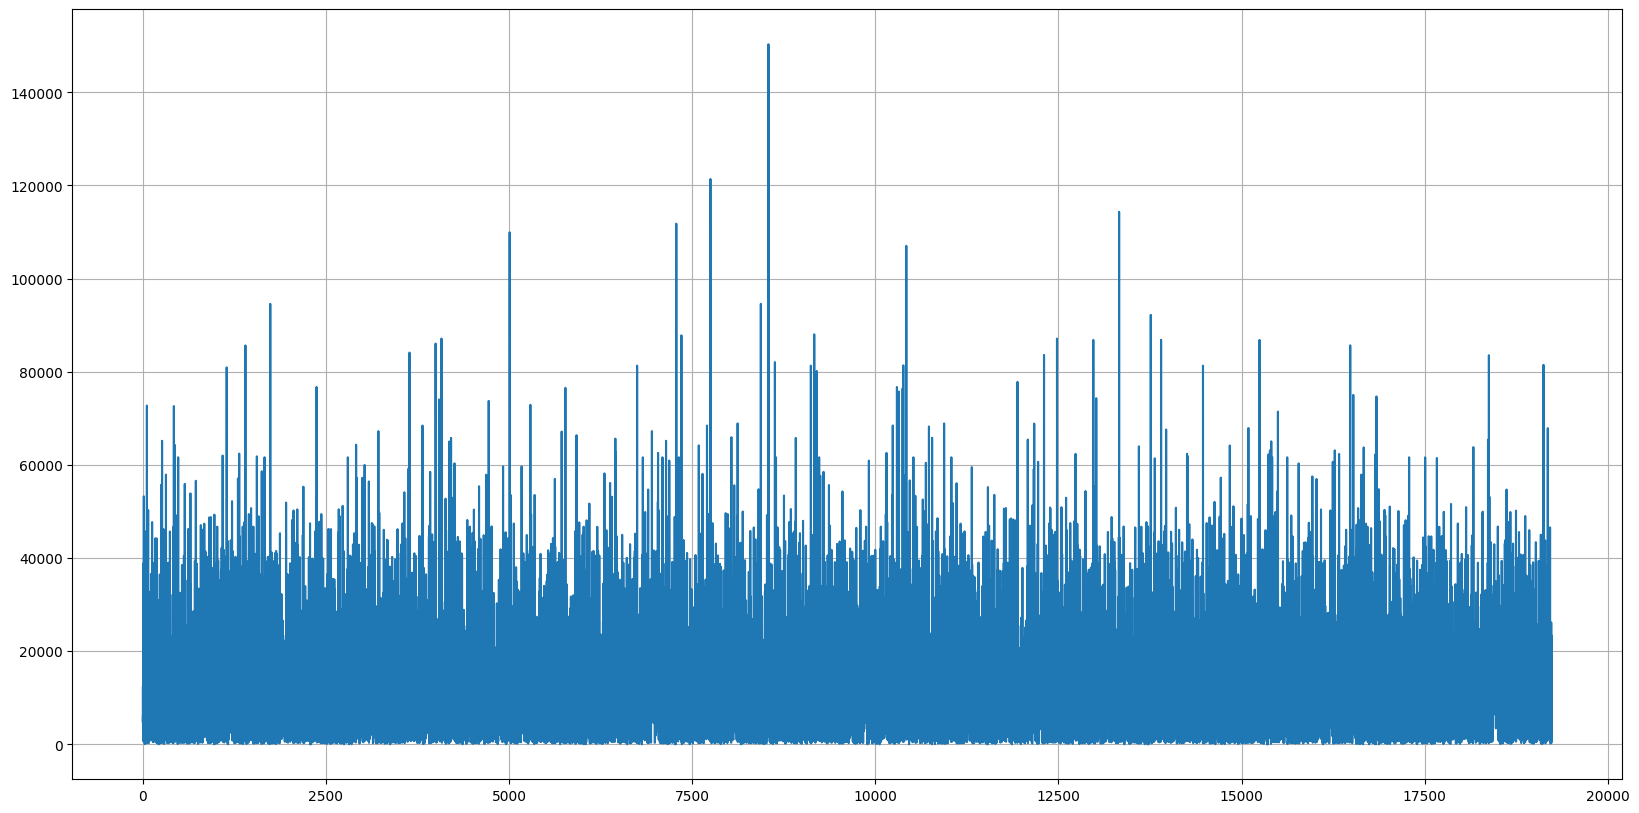

In [104]:
plt.figure(figsize=(20, 10))
plt.plot(predictions)
plt.grid()
plt.show()